In [6]:
# Feel free to import any other libraries and modules.
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

# Part One: Optimization Algorithms
## 1. Gradient Descent
The Gradient Descent (GD) algorithm finds the minimum of a given
function by taking small steps along the function's gradient:

>$\Theta \leftarrow \Theta_0$

>**while** stop condition not met **do**

>$~~~~$$\Theta \leftarrow \Theta - \alpha \nabla_\Theta f(\Theta)$

>**end while**

where $f$ is the function to minimize, $\nabla_\Theta f(\Theta)$
denotes $f$'s gradient at $\Theta$ and $\alpha$ is the learning rate.

**Task1:** Implement the GD algorithm as a function:

  \begin{equation}
      \Theta_{opt} = \text{GD}(f, \Theta_0, \alpha, \rho)
  \end{equation}
where $f$ is a function returning the cost and its gradient with respect to parameter vector $\Theta$, $\Theta_0$ is the initial value, and $\alpha$
is the learning rate. You can assume that $\alpha$. remains constant during the optimization. $\rho$ is stop condition. \\
Then, use the GD algorithm to find the optimum of the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) (Consider $a=1, b=100$).
 \\
Also, plot the values found by GD at subsequent iterations.

## 2. Newton's Method
Newton's method is an iterative optimization algorithm used to find the minimum of a function.
The basic update step in Newton's method is given by:

\begin{equation}
\Theta = \Theta - H^{-1} \cdot \nabla f(\Theta)
\end{equation}


Where  $ H $ is the Hessian matrix of the function at $ \Theta $, and $ H^{-1} $ is the inverse of the Hessian matrix, used to adjust the step size and direction more accurately than just using the gradient alone (as done in gradient descent).

#### Line Search
Sometimes, Newton's method may take too large of a step, which can lead to divergence. To prevent this, a simple **line search** is used. This reduces the step size $ \alpha $ if the function value doesn't improve after the step.

Steps:
1. Compute the gradient and Hessian matrix at the current point.
2. Calculate the step direction by multiplying the inverse of the Hessian with the gradient.
3. Update the point by subtracting the step from the current point.
4. If the function value doesn't improve, reduce the step size $ \alpha $.
5. Repeat until the gradient becomes sufficiently small (close to zero), indicating convergence.



**Task2:** Implement Newton's method and compare it with the gradient descent. You will also need to implement a line search alogithm, e.g. (https://en.wikipedia.org/wiki/Backtracking_line_search) and make sure that the Newton's direction is indeed one along which the function is minimized.


In [7]:
def rosenbrock(x):
    """Returns the value and gradient of Rosenbrock's function at x: 2d vector"""
    x0,x1 = x
    val = (1 - x0)**2 + 100 * (x1 - x0**2)**2
    dv_dx0 = 2 * (x0 - 1) - 4 * 100 * x0 * (x1 - x0**2)
    dv_dx1 = 2 * 100 * (x1 - x0**2)
    grad = np.array([dv_dx0, dv_dx1])

    return val, grad

def rosenbrock_hessian(x):
    """Returns the value, gradient and hessian of Rosenbrock's function at x: 2d vector"""
    x0, x1 = x[0], x[1]
    val, grad = rosenbrock(x)

    # Hessian matrix components
    d2v_dx0x0 = 2 - 4 * 100 * (x1 - 3 * x0**2)
    d2v_dx0x1 = -4 * 100 * x0
    d2v_dx1x0 = -4 * 100 * x0
    d2v_dx1x1 = 2 * 100

    # Hessian matrix
    hessian = np.array([[d2v_dx0x0, d2v_dx0x1],
                [d2v_dx1x0, d2v_dx1x1]])

    return val, grad, hessian


def GD(f, theta0, alpha, stop_tolerance=1e-10, max_steps=1000000):
    """Runs gradient descent algorithm on f.

    Args:
        f: function that when evaluated on a Theta of same dtype and shape as Theta0
            returns a tuple (value, dv_dtheta) with dValuedTheta of the same shape
            as Theta
        theta0: starting point
        alpha: step length
        stop_tolerance: stop iterations when improvement is below this threshold
        max_steps: maximum number of steps
    Returns:
        tuple:
        - theta: optimum theta found by the algorithm
        - history: list of length num_steps containing tuples (theta, (val, dv_dtheta: np.array))

    """
    history = []

    theta = theta0

    step = 0
    prev_val, grad = f(theta)
    history.append((theta, (prev_val, grad)))
    while step < max_steps:
        theta = theta - alpha * grad

        # Evaluate function at new theta
        val, grad = f(theta)

        # Record history
        history.append((theta, (val, grad)))

        # Check for convergence
        if abs(prev_val - val) < stop_tolerance:
            break

        # Update previous value and increment step counter
        prev_val = val
        step += 1

    history.append([theta, f(theta)])
    return theta, history

Found optimum at [0.99964674 0.99929219] in 16855 steps (true minimum is at [1,1])


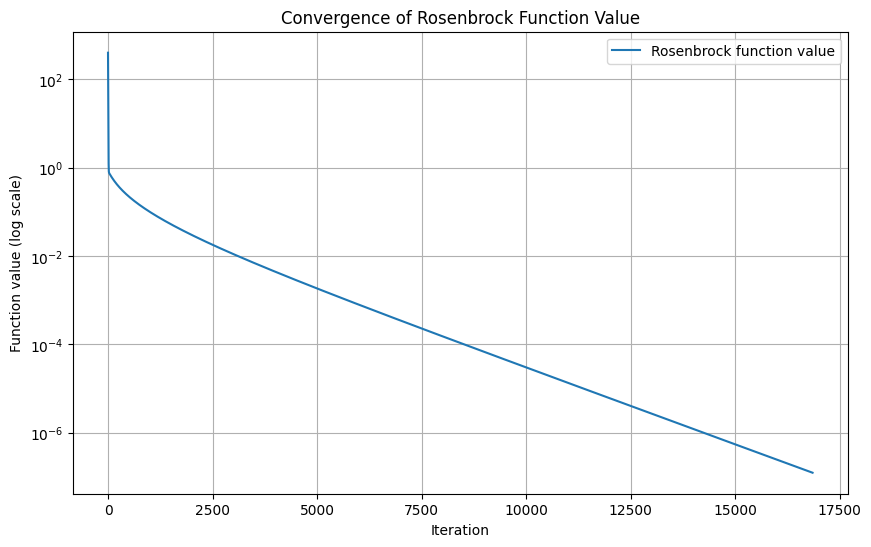

In [8]:
# Find the optimum of rosenbrock function

X0 = [0.,2.]
Xopt, Xhist = GD(rosenbrock, X0, alpha=1e-3, stop_tolerance=1e-10, max_steps=1e6)

print ("Found optimum at %s in %d steps (true minimum is at [1,1])" % (Xopt, len(Xhist)))

# Plot how the value changes over iterations
#TODO
def plot_convergence(history):
    """Plots the convergence of the Rosenbrock function value over iterations.

    Args:
        history (list): List of tuples (theta, (val, grad)) recorded during optimization.
    """
    # Extract function values from history
    values = [entry[1][0] for entry in history]  # Extracts function values

    # Plot function values over iterations
    plt.figure(figsize=(10, 6))
    plt.plot(values, label='Rosenbrock function value')
    plt.yscale('log')  # Log scale for better visibility of convergence
    plt.xlabel('Iteration')
    plt.ylabel('Function value (log scale)')
    plt.title('Convergence of Rosenbrock Function Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the convergence using the history from GD
plot_convergence(Xhist)

In [9]:
import numpy as np

# Newton's Method
def Newton(f, theta0, alpha=1, stop_tolerance=1e-10, max_steps=1000000):
    """Performs Newton's optimization method with a simple line search.

    Args:
        f: function that when evaluated on a Theta of same dtype and shape as Theta0
            returns a tuple (value, gradient, hessian), where gradient and Hessian
            have the same shape as Theta.
        theta0: starting point.
        alpha: step length for backtracking line search (default is 1).
        stop_tolerance: stop iterations when the norm of the gradient is below this threshold.
        max_steps: maximum number of iterations.
    Returns:
        tuple:
        - theta: optimal Theta after convergence or maximum steps.
        - history: list of tuples (theta, value, gradient) containing the optimization path.
    """
    theta = np.array(theta0, dtype=float)
    history = []

    for step in range(int(max_steps)):
        # Evaluate the function to get the value, gradient, and Hessian at the current theta
        value, grad, hessian = f(theta)

        # Record the current state in history
        history.append((theta.copy(), value, grad.copy()))

        # Check for convergence: if the norm of the gradient is below the stop_tolerance, exit
        if np.linalg.norm(grad) < stop_tolerance:
            break
        try:
            hessian_inv = np.linalg.inv(hessian)
        except np.linalg.LinAlgError:
            break

        newton_step = -hessian_inv @ grad

        theta = theta + alpha * newton_step

    return theta, history

X0 = [0., 2.]  # Initial guess
Xopt, Xhist = Newton(rosenbrock_hessian, X0)

print("Found optimum at %s (true minimum is at [1,1])" % Xopt)


Found optimum at [1. 1.] (true minimum is at [1,1])


# Part two: MLP for MNIST Classification
In this part, we are going to use `PyTorch`. If you want to become more familiar with it, check this resource: https://www.learnpytorch.io/

#### In this homework, you need to
- implement SGD optimizer (`./optimizer.py`)
- implement forward and backward for FCLayer (`layers.py`)
- implement forward and backward for SigmoidLayer (`layers.py`)
- implement forward and backward for ReLULayer (`layers.py`)
- implement forward and backward for DropoutLayer (`layers.py`)
- implement train and test process (`solver.py`)

In [10]:
from layers import FCLayer, SigmoidLayer, ReLULayer
from solver import train, test
from optimizer import SGD

In [11]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
# Load MNIST dataset

# Converts PIL image to tensor and scales to [0, 1] and flatten it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

# Load MNIST dataset with the defined transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# One-hot encoding for labels
def decode_label(label, num_classes=10):
    return torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes).float()

# Preprocess labels and combine with transformed images
y_train = [decode_label(label) for _, label in train_dataset]
y_test = [decode_label(label) for _, label in test_dataset]

# Convert the data into tensor datasets for training and testing
train_dataset = TensorDataset(torch.stack([img for img, _ in train_dataset]), torch.stack(y_train))
test_dataset = TensorDataset(torch.stack([img for img, _ in test_dataset]), torch.stack(y_test))

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:11<00:00, 898kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 55.1kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:06<00:00, 242kB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.63MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [13]:
num_epoch = 20

criterion = nn.MSELoss()

# Build MLP with FCLayer and SigmoidLayer you've implemented in layers.py
sigmoidMLP = nn.Sequential(
    FCLayer(784, 128),
    SigmoidLayer(),
    FCLayer(128, 10)
)

# Initialize optimizer you've implemented in optimizer.py
sgd = SGD(params=sigmoidMLP.parameters(), learning_rate=0.01)

# Train the model using train function you've implemented in solver.py
sigmoidMLP = train(sigmoidMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.0771, Average training accuracy: 0.4956

Epoch [1] Average training loss: 0.0556, Average training accuracy: 0.7378

Epoch [2] Average training loss: 0.0506, Average training accuracy: 0.7835

Epoch [3] Average training loss: 0.0482, Average training accuracy: 0.8046

Epoch [4] Average training loss: 0.0466, Average training accuracy: 0.8173

Epoch [5] Average training loss: 0.0456, Average training accuracy: 0.8254

Epoch [6] Average training loss: 0.0448, Average training accuracy: 0.8307

Epoch [7] Average training loss: 0.0442, Average training accuracy: 0.8344

Epoch [8] Average training loss: 0.0437, Average training accuracy: 0.8384

Epoch [9] Average training loss: 0.0432, Average training accuracy: 0.8408

Epoch [10] Average training loss: 0.0429, Average training accuracy: 0.8430

Epoch [11] Average training loss: 0.0426, Average training accuracy: 0.8455

Epoch [12] Average training loss: 0.0423, Average training accuracy: 0.8465

Epoch [1

In [14]:
# Test your model using test function you've implemented in solver.py
test(sigmoidMLP, test_dataloader, device)

The test accuracy is 0.8627.



In [15]:
# Build MLP with FCLayer and ReLULayer
reluMLP = nn.Sequential(
    FCLayer(784, 128),
    ReLULayer(),
    FCLayer(128, 10)
)

# Initialize optimizer
sgd = SGD(reluMLP.parameters(), learning_rate=0.01)

# Train the model
reluMLP = train(reluMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.0712, Average training accuracy: 0.6373

Epoch [1] Average training loss: 0.0467, Average training accuracy: 0.8231

Epoch [2] Average training loss: 0.0399, Average training accuracy: 0.8589

Epoch [3] Average training loss: 0.0357, Average training accuracy: 0.8765

Epoch [4] Average training loss: 0.0327, Average training accuracy: 0.8875

Epoch [5] Average training loss: 0.0305, Average training accuracy: 0.8953

Epoch [6] Average training loss: 0.0288, Average training accuracy: 0.9011

Epoch [7] Average training loss: 0.0274, Average training accuracy: 0.9060

Epoch [8] Average training loss: 0.0262, Average training accuracy: 0.9103

Epoch [9] Average training loss: 0.0253, Average training accuracy: 0.9131

Epoch [10] Average training loss: 0.0244, Average training accuracy: 0.9162

Epoch [11] Average training loss: 0.0237, Average training accuracy: 0.9185

Epoch [12] Average training loss: 0.0231, Average training accuracy: 0.9205

Epoch [1

In [16]:
# Test the model
test(reluMLP, test_dataloader, device)

The test accuracy is 0.9313.



### Overfit the model
Try to overfit the reluMLP model. You can make the model as complex as you like, use subset of the data for training or any other approach you want.
Then add **DropoutLayer** to your model in order to reduce overfitting problem.

In [30]:
#TODO: overfit the reluMLP model
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from layers import FCLayer, ReLULayer, DropoutLayer

complex_reluMLP = nn.Sequential(
    FCLayer(784, 256),
    ReLULayer(),
    FCLayer(256, 256),
    ReLULayer(),
    FCLayer(256, 128),
    ReLULayer(),
    FCLayer(128, 64),
    ReLULayer(),
    FCLayer(64, 10)
)
subset_size = int(0.05 * len(train_dataset)) #more data on training
subset_indices = list(range(subset_size))
subset_train_dataset = Subset(train_dataset, subset_indices)
subset_train_dataloader = DataLoader(subset_train_dataset, batch_size=64, shuffle=True)
sgd_complex = optim.SGD(complex_reluMLP.parameters(), lr=0.01)
complex_reluMLP = train(complex_reluMLP, criterion, sgd_complex, subset_train_dataloader, num_epoch, device=device)



Epoch [0] Average training loss: 2.2664, Average training accuracy: 0.1467

Epoch [1] Average training loss: 2.1597, Average training accuracy: 0.2770

Epoch [2] Average training loss: 2.0158, Average training accuracy: 0.4598

Epoch [3] Average training loss: 1.7997, Average training accuracy: 0.6157

Epoch [4] Average training loss: 1.5092, Average training accuracy: 0.7056

Epoch [5] Average training loss: 1.1966, Average training accuracy: 0.7496

Epoch [6] Average training loss: 0.9375, Average training accuracy: 0.7919

Epoch [7] Average training loss: 0.7652, Average training accuracy: 0.8140

Epoch [8] Average training loss: 0.6492, Average training accuracy: 0.8376

Epoch [9] Average training loss: 0.5648, Average training accuracy: 0.8555

Epoch [10] Average training loss: 0.5111, Average training accuracy: 0.8674

Epoch [11] Average training loss: 0.4696, Average training accuracy: 0.8716

Epoch [12] Average training loss: 0.4348, Average training accuracy: 0.8823

Epoch [1

In [28]:
from layers import DropoutLayer

#TODO: add DropoutLayer to your model
dropout_reluMLP = nn.Sequential(
    FCLayer(784, 256),
    ReLULayer(),
    DropoutLayer(0.2),
    FCLayer(256, 256),
    ReLULayer(),
    DropoutLayer(0.2),
    FCLayer(256, 128),
    ReLULayer(),
    DropoutLayer(0.2),
    FCLayer(128, 64),
    ReLULayer(),
    DropoutLayer(0.2),
    FCLayer(64, 10)
)
sgd_dropout = optim.SGD(dropout_reluMLP.parameters(), lr=0.01
dropout_reluMLP = train(dropout_reluMLP, criterion, sgd_dropout, subset_train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 2.2552, Average training accuracy: 0.1743

Epoch [1] Average training loss: 2.0732, Average training accuracy: 0.3039

Epoch [2] Average training loss: 1.7710, Average training accuracy: 0.4354

Epoch [3] Average training loss: 1.4530, Average training accuracy: 0.5386

Epoch [4] Average training loss: 1.2150, Average training accuracy: 0.6020

Epoch [5] Average training loss: 1.0371, Average training accuracy: 0.6600

Epoch [6] Average training loss: 0.9136, Average training accuracy: 0.7087

Epoch [7] Average training loss: 0.8187, Average training accuracy: 0.7414

Epoch [8] Average training loss: 0.7565, Average training accuracy: 0.7585

Epoch [9] Average training loss: 0.6742, Average training accuracy: 0.7917

Epoch [10] Average training loss: 0.6435, Average training accuracy: 0.7948

Epoch [11] Average training loss: 0.5927, Average training accuracy: 0.8226

Epoch [12] Average training loss: 0.5624, Average training accuracy: 0.8318

Epoch [1

In [29]:
test(dropout_reluMLP, test_dataloader, device)

The test accuracy is 0.9048.



In [31]:
test(complex_reluMLP, test_dataloader, device)

The test accuracy is 0.8924.



as we see the drop out helped our model to achieve higher accuracy and the overfitting caused model to fit very much to training data and not be good generalization. for better results in general we should avoid getting overfit and use drop out for better functioning and better training of the model.